In [34]:
!pip install opencv-python

!pip install scikit-image


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 6.1 MB/s eta 0:00:000:00:01m eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 7.5 MB/s eta 0:00:007.7 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 7.6 MB/s eta 0:00:007.8 MB/s eta 0:00:01


In [89]:
import pandas as pd 
import os 
import cv2
import time
from sklearn.cluster import KMeans
from skimage.feature import hog
from skimage import exposure
import matplotlib.pyplot as plt
import math
import numpy as np
from skimage import transform
from sklearn.cluster import DBSCAN

En primer lugar se toma los datos y se realiza una union para el dataset de Anti-Spoofing Dataset, 30,000 sets

In [87]:
def obtener_imagenes_video(video_path):    
    cap = cv2.VideoCapture(video_path)
    
    # Obtener información del video
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = frame_count / fps
    
    # Capturar imágenes
    times = [0, duration / 2, duration - 1]
    for t in times:
        cap.set(cv2.CAP_PROP_POS_MSEC, t * 1000)
        ret, frame = cap.read()
        if ret:
            timestamp = int(time.time())
            cv2.imwrite(f'./data/output_{timestamp}_{int(t)}.jpg', frame)
    
    cap.release()

def preprocess_image(img, target_size=(1000, 1000)):
    """Redimensiona la imagen a un tamaño fijo y convierte a uint8."""
    img_resized = transform.resize(img, target_size)
    return (img_resized * 255).astype(np.uint8)
    
def graficar_imagenes_hog(hog_images, filenames, labels):
    """
    Grafica imágenes HOG junto con sus nombres y etiquetas.

    Parámetros:
    - hog_images: Lista o array de imágenes HOG.
    - filenames: Lista de nombres de archivos correspondientes a las imágenes.
    - labels: Lista de etiquetas correspondientes a las imágenes.
    """
    max_images = len(hog_images)  # Total de imágenes en el conjunto
    num_images = min(len(hog_images), max_images)

    # Calcular filas y columnas
    cols = 3  # Número de columnas
    rows = math.ceil(num_images / cols)  # Número de filas necesarias

    # Graficar las imágenes HOG junto con sus nombres y etiquetas
    plt.figure(figsize=(15, 5 * rows))  # Ajustar el tamaño de la figura según el número de filas
    for i in range(num_images):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(hog_images[i], cmap='gray')  # Mostrar la imagen HOG en escala de grises
        plt.title(f"{filenames[i][7:]}: {labels[i]}")  # Mostrar el nombre del archivo y la etiqueta
        plt.axis('off')  # Ocultar los ejes para mejor visualización
    plt.tight_layout()
    plt.show()
def entrenar_y_predecir_kmeans(personas_features, personas_hog_images, personas_filenames, test_size=0.2, random_state=123, n_clusters=3):
    # Convertir las características a un array de numpy
    personas_features = np.array(personas_features)
    
    # Dividir los datos en entrenamiento y prueba
    X_train, X_test, hog_images_train, hog_images_test, filenames_train, filenames_test = train_test_split(
        personas_features, personas_hog_images, personas_filenames, test_size=test_size, random_state=random_state
    )
    
    # Entrenar el modelo KMeans en los datos de entrenamiento
    kmeans_model = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=10).fit(X_train)
    
    # Predecir las etiquetas de los datos de prueba
    labels_test = kmeans_model.predict(X_test)
    
    # Imprimir los resultados de las imágenes en el conjunto de prueba
    print("Etiquetas asignadas por KMeans para las imágenes del conjunto de prueba:")
    for filename, label in zip(filenames_test, labels_test):
        print(f"{filename[7:]}: {label}")
    
    # Retornar los valores de prueba para que puedas usarlos posteriormente
    return X_test, hog_images_test, filenames_test, labels_test, kmeans_model
def entrenar_y_predecir_dbscan(personas_features, personas_hog_images, personas_filenames, test_size=0.2, random_state=123, eps=0.5, min_samples=5):
    # Convertir las características a un array de numpy
    personas_features = np.array(personas_features)
    
    # Dividir los datos en entrenamiento y prueba
    X_train, X_test, hog_images_train, hog_images_test, filenames_train, filenames_test = train_test_split(
        personas_features, personas_hog_images, personas_filenames, test_size=test_size, random_state=random_state
    )
    
    # Entrenar el modelo DBSCAN en los datos de entrenamiento
    dbscan_model = DBSCAN(eps=eps, min_samples=min_samples).fit(X_train)
    
    # Predecir las etiquetas de los datos de prueba
    labels_test = dbscan_model.fit_predict(X_test)
    
    # Imprimir los resultados de las imágenes en el conjunto de prueba
    print("Etiquetas asignadas por DBSCAN para las imágenes del conjunto de prueba:")
    for filename, label in zip(filenames_test, labels_test):
        print(f"{filename[7:]}: {label}")
    
    # Retornar los valores de prueba para que puedas usarlos posteriormente
    return X_test, hog_images_test, filenames_test, labels_test, dbscan_model
def cargar_imagenes_carpeta(ruta_base, filtro_imagen=None, filtro_caracteristicas=None):
    images = []
    features = []
    filenames = []

    # Recorre todos los subdirectorios y archivos
    for root, dirs, files in os.walk(ruta_base):
        for filename in files:
            if filename.endswith(('.png', '.jpg', '.jpeg')):  # Procesa solo archivos de imagen
                ruta_imagen = os.path.join(root, filename)
                img = cv2.imread(ruta_imagen)

                if img is not None:
                    height, width, _ = img.shape
                    img_resized = preprocess_image(img)  # Preprocesamiento de la imagen
                    img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)

                    # Aplica el filtro de imagen personalizado si se pasa uno
                    if filtro_imagen is not None:
                        img_procesada = filtro_imagen(img_gray)
                    else:
                        img_procesada = img_gray  # Si no hay filtro, usa la imagen en escala de grises

                    # Aplica el filtro de características (HOG u otro)
                    if filtro_caracteristicas is not None:
                        caracteristicas, imagen_procesada = filtro_caracteristicas(img_procesada)
                    else:
                        # Si no se pasa un filtro de características, por defecto se usa HOG
                        caracteristicas, imagen_procesada = hog(img_procesada, pixels_per_cell=(8, 8), 
                                                                cells_per_block=(2, 2), visualize=True)
                    
                    # Ajustar la imagen procesada si es necesario
                    imagen_procesada = exposure.rescale_intensity(imagen_procesada, out_range=(0, 1))

                    # Almacenar los resultados
                    features.append(caracteristicas)
                    images.append(imagen_procesada)
                    filenames.append(ruta_imagen)  # Guarda la ruta completa de la imagen

    return np.array(images), np.array(features), filenames


como el dataset tiene videos estos se colocan en la carpeta dataset1 para despues usar la funcion de obtener imagenes la cual extrae 3 fotografias al inicio, en el medio y al final de los videos


In [95]:
#path_videos_dataset1 = './data/dataset1'
#videos_dataset1 = os.listdir(path_videos_dataset1)
#videos_dataset1

['0001ffba3c--62960f430bd50b2755f74916__Galaxy M31__M2003J15SG.mp4',
 'cut-0001e96803--62663cf6d21d14509973bcb4.mp4',
 '0001e96803--6239cf6720237d576aafbe45.mp4',
 '0001ffba3c--6289196875a5cf63cd0cb302__Samsung galaxy s20 __IPhone 6s plus.mp4',
 '0001e96803--6239cf6720237d576aafbe45__Samsung Galaxy a22.mp4',
 'cut-0001e96803--623955e76e1ee5175569a12b.mp4',
 '0001e96803--623955e76e1ee5175569a12b.mp4',
 '0001ffba3c--6295ba1f8753764e91dcf5df__Poco X3 Pro__Tecno Pouvoir 4.mp4',
 'cut-0001e96803--62294efac72a824e5bb369f3.mp4',
 'cut-0001e96803--62457bc94ff454214e8af551.mp4',
 'cut-0001e96803--624508e961974a65884d9fd3.mp4',
 '0001ffba3c--628c9dbb2579312f1ac7ee6f__-  20__- 22.mp4',
 '0001ffba3c--629066494796d7421dad66b7__iPhone xr __iPhone 6s.MOV',
 '0001e96803--62457bc94ff454214e8af551__Infinix note 11.mp4',
 'cut-0001e96803--6228928cb608822f9f53589e.mp4',
 '0001e96803--6228928cb608822f9f53589e__Xiaomi redmi note 9 pro.mp4',
 '0001ffba3c--628e621c6789b1401e3cb184__Honor 50__Samsung note 9.mp

In [26]:
#for videos in videos_dataset1:
#    obtener_imagenes_video(f'{path_videos_dataset1}/{videos}')

se realiza un analisis de clustering para la persona 1

se realiza pruebas de kmeans usando hog y sin filtros

In [80]:
personas_hog_images, personas_features, personas_filenames = cargar_imagenes_carpeta('./data')

In [81]:
X_test, hog_images_test, filenames_test, labels_test, kmeans_model = entrenar_y_predecir_kmeans(personas_features, personas_hog_images, personas_filenames)


Etiquetas asignadas por KMeans para las imágenes del conjunto de prueba:
persona 7/selfie2.jpg: 1
persona 9/selfie2.jpg: 1
persona 4/sp8.jpg: 1
persona 8/sp8.jpg: 1
persona 9/sp1.jpg: 1
persona 7/sp1.jpg: 2
persona 7/sp4.jpg: 1
persona 3/sp1.jpg: 2
persona 4/selfie5.jpg: 1
persona 7/sp2.jpg: 2
persona 8/selfie1.jpg: 1
persona 9/selfie1.jpg: 1
persona 4/selfie1.jpg: 1
persona 3/sp8.jpg: 1
persona 8/sp2.jpg: 1
persona 2/selfie1.jpg: 1
persona 4/sp10.jpg: 1
persona 5/selfie2.jpg: 1
persona 3/sp2.jpg: 2
persona 4/sp5.jpg: 1
persona 5/sp4.jpg: 1


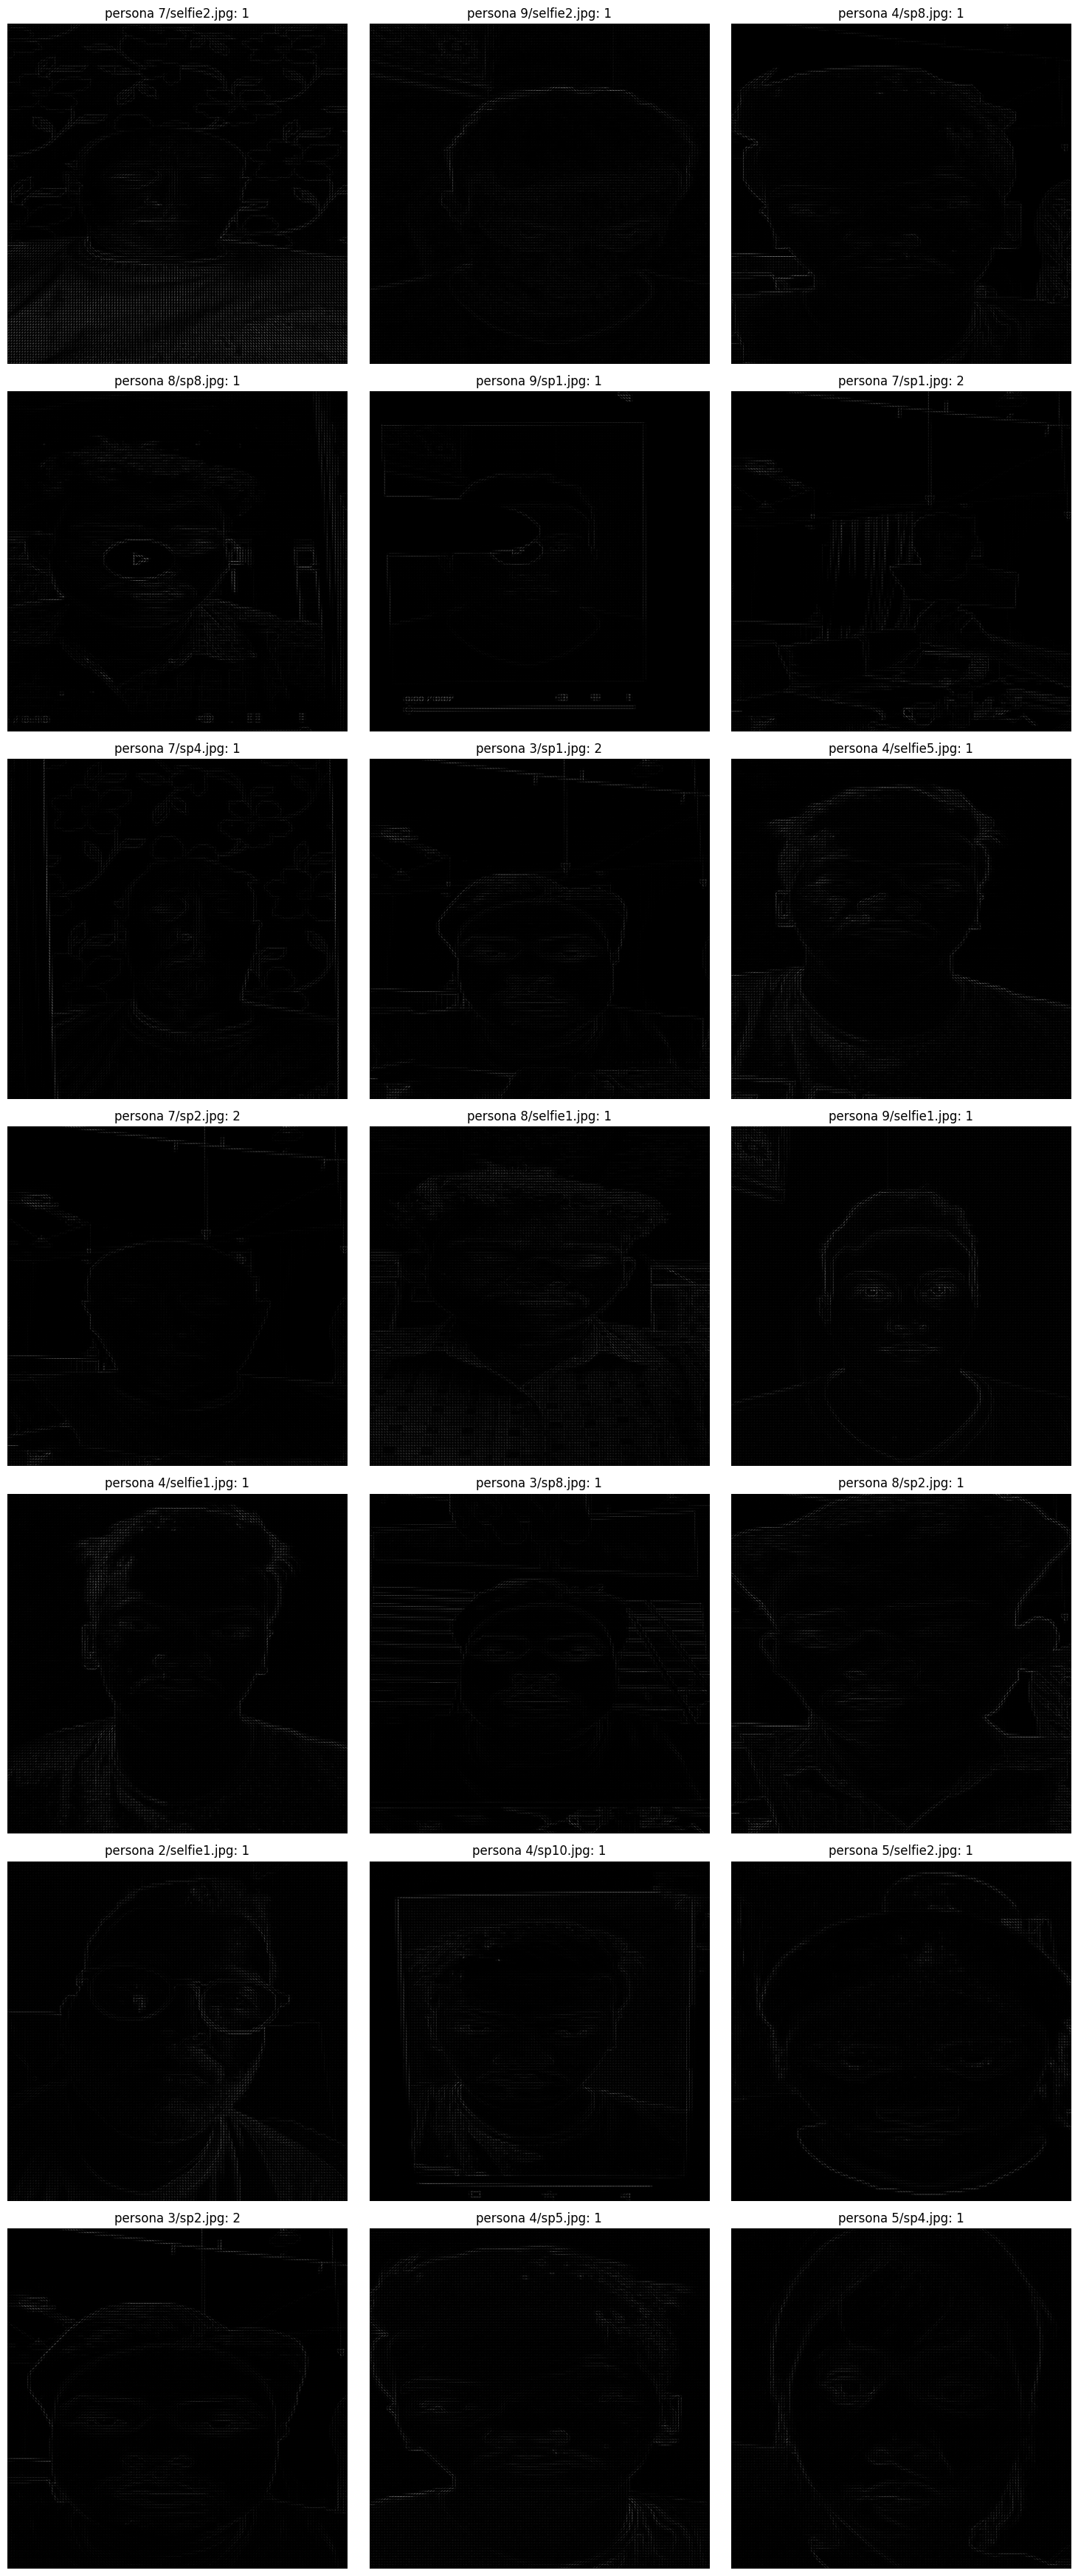

In [84]:
# Supongamos que tienes hog_images_test, filenames_test y labels_test
graficar_imagenes_hog(hog_images_test, filenames_test, labels_test)

de lo anterior se evidencia que el solo uso de kmeans y el filtro de blanco y negro no es suficiente para separar los componentes 


In [85]:
def filtro_sobel_Gaussiana(img):
    sobel_x = cv2.Sobel(img, cv2.CV_8U, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(img, cv2.CV_8U, 0, 1, ksize=3)
    gaussiana = cv2.GaussianBlur(img, (5, 5), 0)
    
    # Combinar los resultados de Sobel y Gaussiana (puedes ajustar esto como prefieras)
    img_combined = cv2.addWeighted(sobel_x, 0.5, sobel_y, 0.5, 0)
    img_combined = cv2.addWeighted(img_combined, 0.5, gaussiana, 0.5, 0)
    
    return img_combined
    
imagenes, caracteristicas, nombres = cargar_imagenes_carpeta('./data', filtro_imagen=filtro_sobel_Gaussiana)
X_test, hog_images_test, filenames_test, labels_test, kmeans_model = entrenar_y_predecir_kmeans(caracteristicas, imagenes, nombres)



Etiquetas asignadas por KMeans para las imágenes del conjunto de prueba:
persona 7/selfie2.jpg: 2
persona 9/selfie2.jpg: 2
persona 4/sp8.jpg: 1
persona 8/sp8.jpg: 2
persona 9/sp1.jpg: 1
persona 7/sp1.jpg: 1
persona 7/sp4.jpg: 1
persona 3/sp1.jpg: 1
persona 4/selfie5.jpg: 2
persona 7/sp2.jpg: 1
persona 8/selfie1.jpg: 2
persona 9/selfie1.jpg: 2
persona 4/selfie1.jpg: 2
persona 3/sp8.jpg: 2
persona 8/sp2.jpg: 2
persona 2/selfie1.jpg: 2
persona 4/sp10.jpg: 2
persona 5/selfie2.jpg: 2
persona 3/sp2.jpg: 1
persona 4/sp5.jpg: 2
persona 5/sp4.jpg: 2


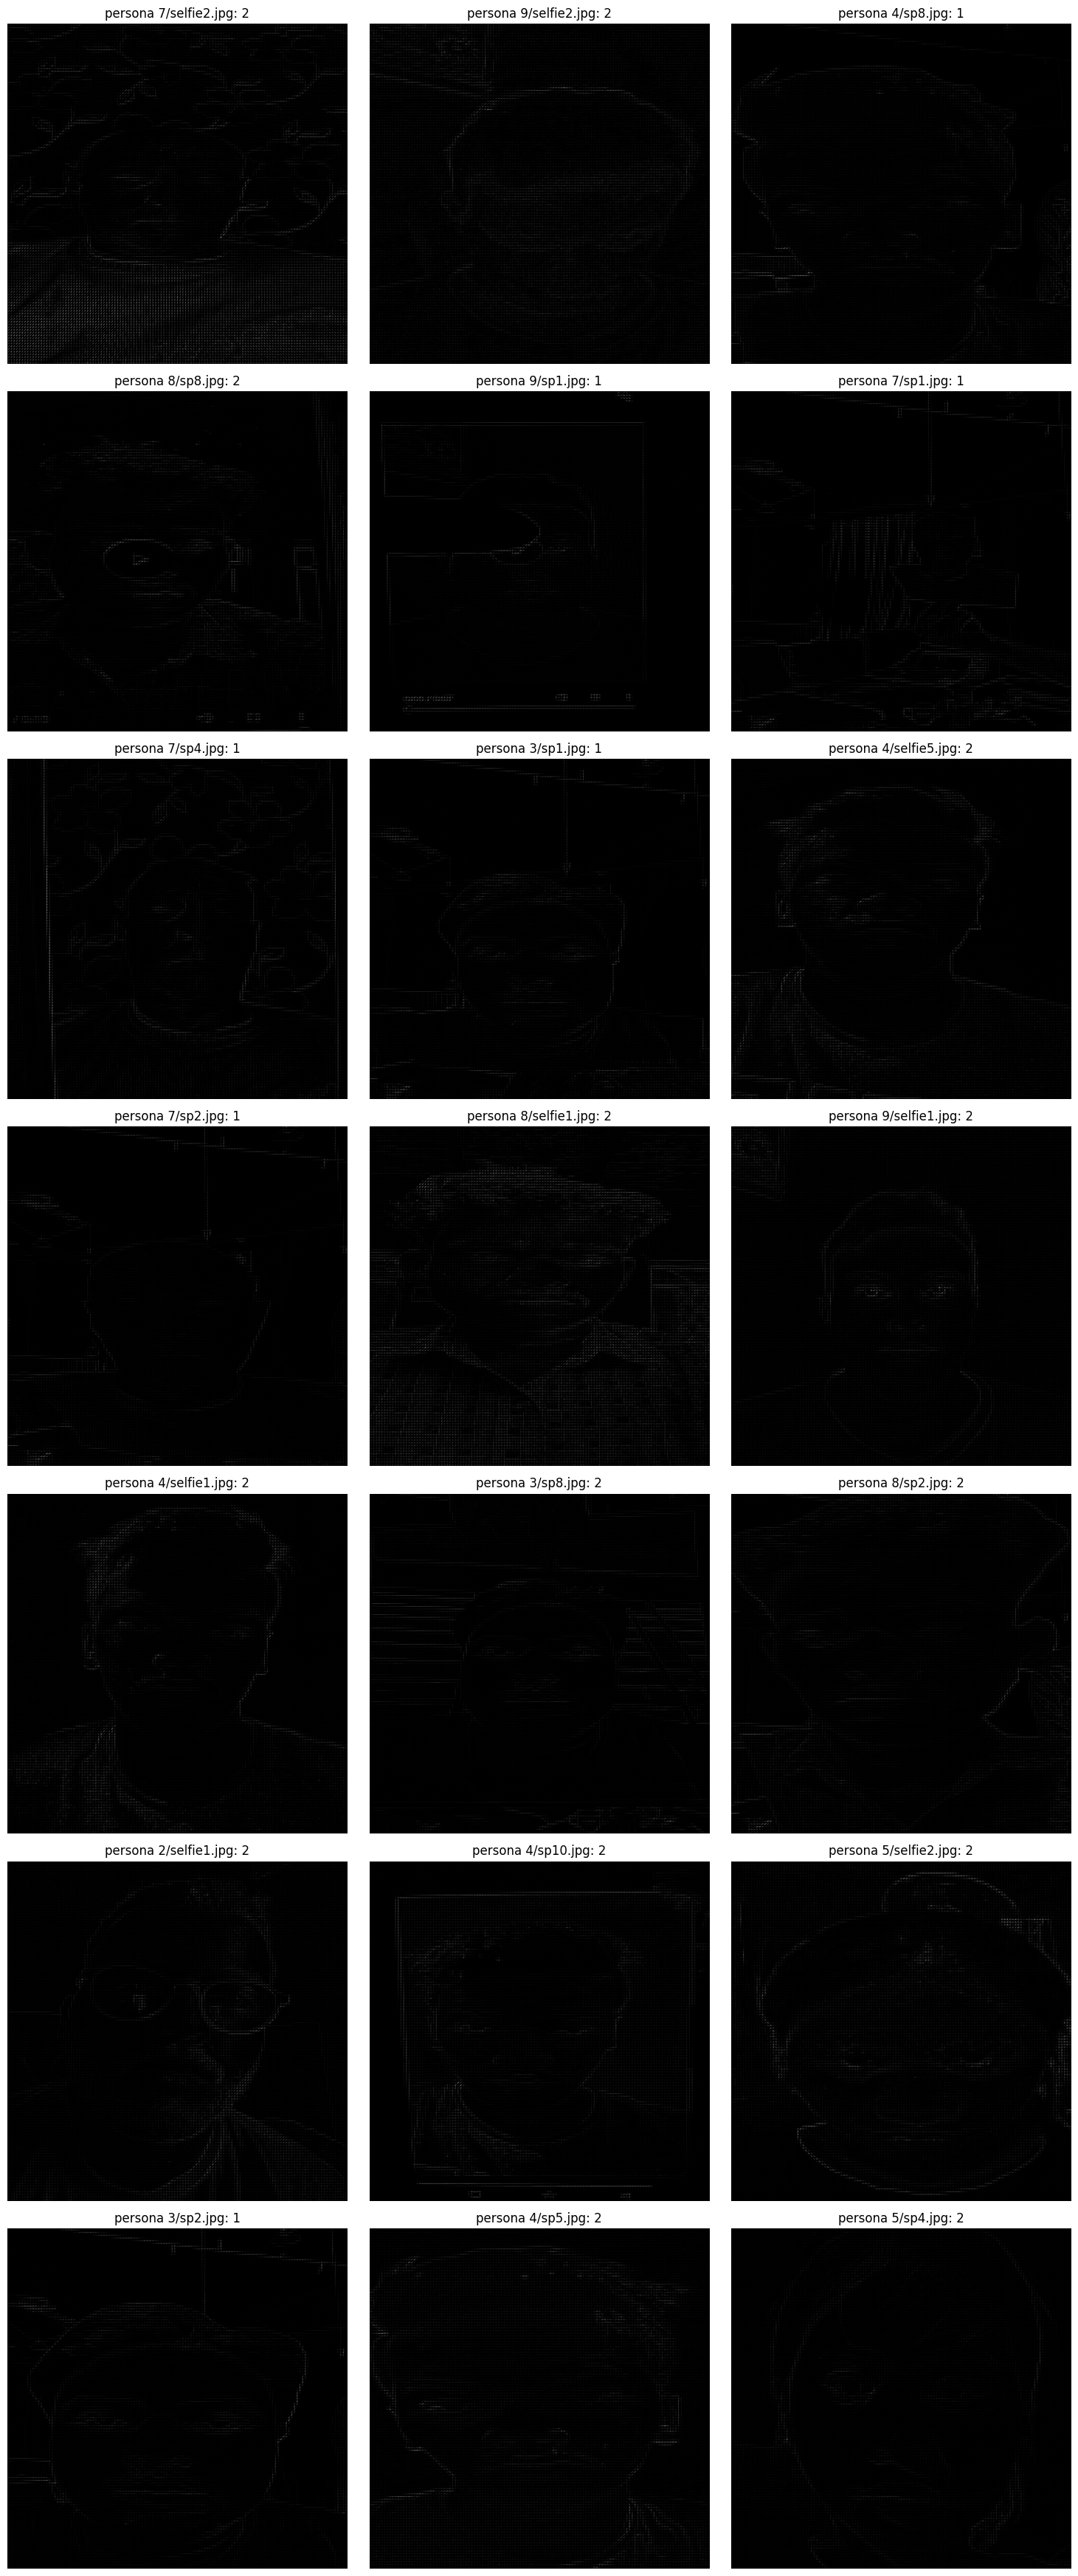

In [86]:
# Supongamos que tienes hog_images_test, filenames_test y labels_test
graficar_imagenes_hog(hog_images_test, filenames_test, labels_test)

como se puede notar ahora se hace una mejor separacion del filtro pero con dificultades en las fotos de spooging que son recortadas


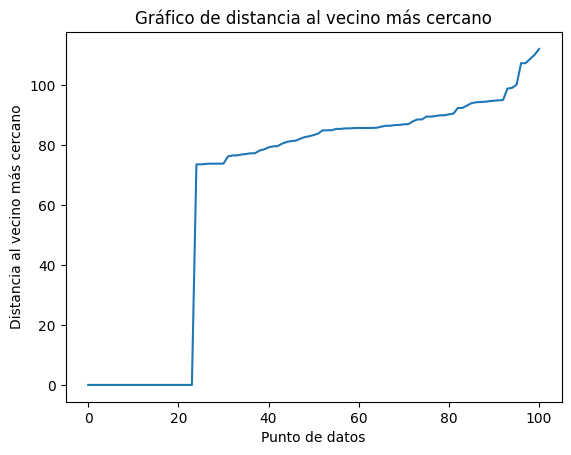

Etiquetas asignadas por DBSCAN:
persona 7/sp1.jpg: -1
persona 7/sp7.jpg: -1
persona 7/sp5.jpg: -1
persona 7/selfie1.jpg: -1
persona 7/sp2.jpg: -1
persona 7/sp4.jpg: -1
persona 7/sp3.jpg: -1
persona 7/selfie3.jpg: -1
persona 7/selfie2.jpg: -1
persona 7/sp6.jpg: -1
persona 7/selfie4.jpg: -1
persona 6/sp1.jpg: -1
persona 6/sp7.jpg: -1
persona 6/sp5.jpg: -1
persona 6/selfie1.jpg: -1
persona 6/sp2.jpg: -1
persona 6/sp4.jpg: -1
persona 6/sp3.jpg: -1
persona 6/selfie2.jpg: -1
persona 6/sp6.jpg: -1
persona 8/sp1.jpg: -1
persona 8/sp7.jpg: -1
persona 8/sp5.jpg: -1
persona 8/selfie1.jpg: -1
persona 8/sp2.jpg: -1
persona 8/sp4.jpg: -1
persona 8/sp3.jpg: -1
persona 8/selfie3.jpg: -1
persona 8/sp8.jpg: -1
persona 8/selfie2.jpg: -1
persona 8/sp6.jpg: -1
persona 8/selfie4.jpg: -1
persona 5/sp1.jpg: -1
persona 5/selfie1.jpg: -1
persona 5/sp2.jpg: -1
persona 5/sp4.jpg: -1
persona 5/sp3.jpg: -1
persona 5/selfie3.jpg: -1
persona 5/selfie2.jpg: -1
persona 5/selfie4.jpg: -1
persona 2/sp1.jpg: -1
persona 2/

In [91]:
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

# Ajustar eps
def calcular_eps_optimo(features):
    # Calcular las distancias al vecino más cercano
    neigh = NearestNeighbors(n_neighbors=2)
    nbrs = neigh.fit(features)
    distances, indices = nbrs.kneighbors(features)
    
    # Ordenar las distancias de menor a mayor
    distances = np.sort(distances[:, 1], axis=0)
    
    # Graficar la distancia para visualizar un buen valor de eps
    plt.plot(distances)
    plt.title("Gráfico de distancia al vecino más cercano")
    plt.xlabel("Punto de datos")
    plt.ylabel("Distancia al vecino más cercano")
    plt.show()

# Llamar a esta función para encontrar un valor de eps óptimo
calcular_eps_optimo(personas_features)

# Ajustar DBSCAN con eps y min_samples encontrados
dbscan_model = DBSCAN(eps=0.5, min_samples=5).fit(personas_features)

# Predecir etiquetas
labels = dbscan_model.labels_

# Imprimir etiquetas
print("Etiquetas asignadas por DBSCAN:")
for filename, label in zip(personas_filenames, labels):
    print(f"{filename[7:]}: {label}")


In [ ]:
personas_hog_images, personas_features, personas_filenames = cargar_imagenes_carpeta('./data')

In [98]:
# Supongamos que ya tienes las características HOG, imágenes y nombres de archivos
X_test, hog_images_test, filenames_test, labels_test, dbscan_model = entrenar_y_predecir_dbscan(personas_features, personas_hog_images, personas_filenames, eps=90, min_samples=10)


Etiquetas asignadas por DBSCAN para las imágenes del conjunto de prueba:
persona 7/selfie2.jpg: -1
persona 9/selfie2.jpg: 0
persona 4/sp8.jpg: -1
persona 8/sp8.jpg: -1
persona 9/sp1.jpg: -1
persona 7/sp1.jpg: -1
persona 7/sp4.jpg: -1
persona 3/sp1.jpg: -1
persona 4/selfie5.jpg: 0
persona 7/sp2.jpg: -1
persona 8/selfie1.jpg: 0
persona 9/selfie1.jpg: 0
persona 4/selfie1.jpg: 0
persona 3/sp8.jpg: -1
persona 8/sp2.jpg: 0
persona 2/selfie1.jpg: 0
persona 4/sp10.jpg: -1
persona 5/selfie2.jpg: 0
persona 3/sp2.jpg: -1
persona 4/sp5.jpg: 0
persona 5/sp4.jpg: 0


In [100]:
imagenes, caracteristicas, nombres = cargar_imagenes_carpeta('./data', filtro_imagen=filtro_sobel_Gaussiana)
X_test, hog_images_test, filenames_test, labels_test, dbscan_model = entrenar_y_predecir_dbscan(caracteristicas, imagenes, nombres, eps=90, min_samples=10)

Etiquetas asignadas por DBSCAN para las imágenes del conjunto de prueba:
persona 7/selfie2.jpg: -1
persona 9/selfie2.jpg: 0
persona 4/sp8.jpg: -1
persona 8/sp8.jpg: -1
persona 9/sp1.jpg: -1
persona 7/sp1.jpg: -1
persona 7/sp4.jpg: -1
persona 3/sp1.jpg: -1
persona 4/selfie5.jpg: 0
persona 7/sp2.jpg: -1
persona 8/selfie1.jpg: 0
persona 9/selfie1.jpg: 0
persona 4/selfie1.jpg: 0
persona 3/sp8.jpg: 0
persona 8/sp2.jpg: 0
persona 2/selfie1.jpg: 0
persona 4/sp10.jpg: 0
persona 5/selfie2.jpg: 0
persona 3/sp2.jpg: -1
persona 4/sp5.jpg: 0
persona 5/sp4.jpg: 0


como se puede observar al usar el filtro de sobel mas el suavisado gaussiana se clasifica de mejor manera las imagenes 